In [1]:
import os
import ee
import numpy as np
import pandas as pd
import geopandas as gp
import multiprocessing as mp
from tqdm import tqdm
ee.Initialize()

In [2]:
def gdf_to_ee_poly(gdf, simplify = False):

	if simplify:
		gdf = gdf.geometry.simplify(0.01)
	
	lls = gdf.geometry.iloc[0]
	x,y = lls.exterior.coords.xy
	coords = [list(zip(x,y))]
	area = ee.Geometry.Polygon(coords)

	return area


In [15]:
def return_mean(ImageCollection,resolution, scaling_factor, variable, startdate, enddate, area):
    start = ee.Date(startdate)
    end = ee.Date(enddate)

    im = ee.Image(ImageCollection.select(var).filterDate(start, end).first())
    scaled_im = im.multiply(scaling_factor)
    results_dict  = scaled_im.reduceRegion(
        reducer = ee.Reducer.mean(),
        geometry = area,
        scale = resolution,
        bestEffort= True)

    total = results_dict.getInfo()[variable]
    return total

def process_poly(polygon):
    
    area_shp = gdf.loc[i]['geometry']
    area_gdf = gp.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[area_shp])
    area = gdf_to_ee_poly(area_gdf)
    
    dt_range = pd.date_range("2002-01-01", '2002-01-10', freq = 'd') # CHANGE THESE DATES 
    results = {}

    for date in tqdm(dt_range): 
        startdate = date
        enddate = date + pd.Timedelta(days=1)

        mean = return_mean(ImageCollection, resolution,scaling_factor, var,startdate,enddate,area)
        results[date.strftime('%Y-%m-%d')] = mean
        
    tsdf = pd.DataFrame([results.keys(), results.values()]).T
    tsdf.columns = ['date',var]
    tsdf.set_index("date", inplace = True)
        
    return tsdf

In [16]:
ImageCollection = ee.ImageCollection("MODIS/006/MCD43A4")
resolution = 500
scaling_factor = 0.0001
var = 'Nadir_Reflectance_Band1'

gdf = gp.read_file("../shape/gadm36_BGD_4.shp")

In [19]:
outdir= "../data"
if not os.path.exists(outdir):
    os.mkdir(outdir)

for i in range(len(gdf))[:1]:
    area_shp = gdf.loc[i]['geometry']
    area_gdf = gp.GeoDataFrame(insdex=[0], crs='epsg:4326', geometry=[area_shp])
    area = gdf_to_ee_poly(area_gdf)
    name = gdf.loc[i]['GID_4']
    outfn = os.path.join(outdir,name+".csv")
    if not os.path.exists(outfn):
        data = process_poly(area)
        data.to_csv(outfn)
    else:
        continue

100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


<AxesSubplot:xlabel='date'>

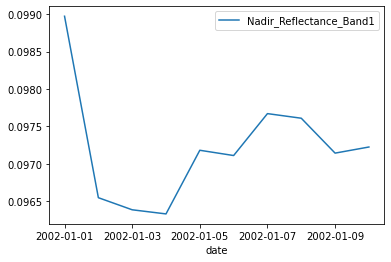

In [21]:
data.plot()